In [471]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [472]:
# Load data
train_data = pd.read_csv("../../data/raw/train.csv")
test_data = pd.read_csv("../../data/raw/test.csv")

In [473]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [474]:
# Function to convert datetime column
def convert_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Extract date and time components
    df['year'] = df['datetime'].dt.year
    df['year'] = df['year'] - np.min(df['year'] - 1)
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour

    return df

# Apply datetime conversion to both train and test datasets
train_data = convert_datetime(train_data)
test_data = convert_datetime(test_data)

In [475]:
# Save original columns for both train and test data
train_columns = train_data.columns
test_columns = test_data.columns

# Add dummy variables for train and test data
train_data['is_train'], train_data['is_test'] = True, False
test_data['is_train'], test_data['is_test'] = False, True

In [476]:
# Combine train and test datasets based on datetime order
combined_data = pd.concat([train_data, test_data], axis=0).sort_values('datetime').reset_index(drop=True)

# Save length of train dataset
n_train = len(train_data)

# Reset index
combined_data = combined_data.reset_index(drop=True)

In [477]:
combined_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,is_train,is_test
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,1,1,1,0,True,False
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,1,1,1,1,True,False
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,1,1,1,2,True,False
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,1,1,1,3,True,False
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,1,1,1,4,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2,12,31,19,False,True
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2,12,31,20,False,True
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,2,12,31,21,False,True
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,2,12,31,22,False,True


ADF Statistic: -16.988217
p-value: 0.000000
Distribution is stationary
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


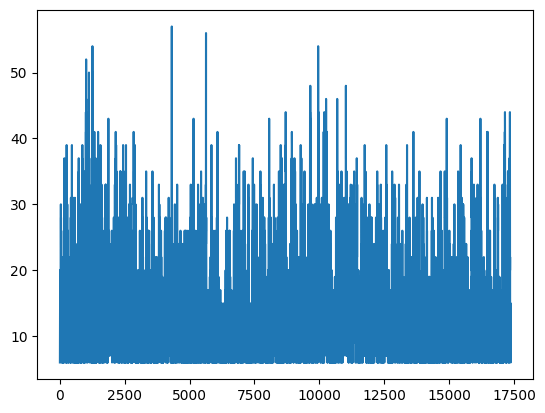

In [478]:
# Check for stationarity of wind speed
mask = combined_data['windspeed'] != 0
combined_data[mask]['windspeed'].plot()

# Check for stationarity of wind speed with hypothesis test
from statsmodels.tsa.stattools import adfuller

result = adfuller(combined_data[mask]['windspeed'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Print if the distribution is stationary or not
if result[1] < 0.05:
    print('Distribution is stationary')
else:
    print('Distribution is non-stationary')

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


In [479]:
def remove_outliers(df, column):
    # Calculate z-score
    z = np.abs((df[column] - df[column].mean()) / df[column].std())
    
    # Set outliers to zero
    df.loc[z > 3, column] = 0
    
    return df

# Remove outliers from windspeed
processed_data = remove_outliers(combined_data, 'windspeed')

In [480]:
def interpolate_wind_gaps(data):
    """
    Handles missing values in windspeed using interpolation.

    Parameters:
    data (DataFrame): The combined dataset containing the windspeed column.

    Returns:
    DataFrame: The combined dataset with the interpolated windspeed values.
    """

    # Convert windspeed column to numeric, replacing non-numeric values with NaN
    data['windspeed'] = pd.to_numeric(data['windspeed'], errors='coerce')

    # Set to zero negative values in windspeed
    data['windspeed'] = data['windspeed'].apply(lambda x: 0 if x < 0 else x)

    # Replace 0 values in windspeed with NaN
    data['windspeed_interp'] = data['windspeed'].replace(0, np.nan)

    # Count number of missing values in windspeed_interp
    n_missing = data['windspeed_interp'].isnull().sum()
    print(f"Number of missing values in windspeed_interp: {n_missing}")

    # Interpolate missing values in windspeed column
    data['windspeed_interp'] = data['windspeed_interp'].interpolate(method='spline', order=3)

    # Count number of missing values in windspeed_interp
    n_missing = data['windspeed_interp'].isnull().sum()
    print(f"Number of missing values in windspeed_interp after interpolation: {n_missing}")

    return data

# Apply fill_wind_gaps function to the combined dataset
processed_data = interpolate_wind_gaps(processed_data)

# Use bfill and ffill to fill remaining missing values
processed_data = processed_data.bfill()
processed_data = processed_data.ffill()
print(f'Number of missing values in windspeed_interp after everything: {processed_data.isnull().sum().sum()}')

Number of missing values in windspeed_interp: 2287
Number of missing values in windspeed_interp after interpolation: 5
Number of missing values in windspeed_interp after everything: 0


In [481]:
def smooth_features(processed_data, features_to_smooth):
    """
    Smooths features using a rolling average.

    Parameters:
    processed_data (DataFrame): The combined dataset containing the features to smooth.
    features_to_smooth (list): A list of features to smooth.

    Returns:
    DataFrame: The combined dataset with the smoothed features.
    """

    # Smooth features using a rolling average
    for feature in features_to_smooth:
        processed_data[feature] = processed_data[feature].rolling(window=5).mean()

    return processed_data

# Apply smooth_features function to the combined dataset
features_to_smooth = ['temp', 'atemp', 'windspeed_interp', 'humidity']
processed_data = smooth_features(processed_data, features_to_smooth)

In [482]:
processed_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,is_train,is_test,windspeed_interp
0,2011-01-01 00:00:00,1,0,0,1,NaN,NaN,NaN,0.0000,3.0,13.0,16.0,1,1,1,0,True,False,NaN
1,2011-01-01 01:00:00,1,0,0,1,NaN,NaN,NaN,0.0000,8.0,32.0,40.0,1,1,1,1,True,False,NaN
2,2011-01-01 02:00:00,1,0,0,1,NaN,NaN,NaN,0.0000,5.0,27.0,32.0,1,1,1,2,True,False,NaN
3,2011-01-01 03:00:00,1,0,0,1,NaN,NaN,NaN,0.0000,3.0,10.0,13.0,1,1,1,3,True,False,NaN
4,2011-01-01 04:00:00,1,0,0,1,9.512,14.091,78.2,0.0000,0.0,1.0,1.0,1,1,1,4,True,False,6.00320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.824,13.637,49.8,11.0014,4.0,84.0,88.0,2,12,31,19,False,True,9.59976
17375,2012-12-31 20:00:00,1,0,1,2,10.660,13.334,52.8,11.0014,4.0,84.0,88.0,2,12,31,20,False,True,10.00042
17376,2012-12-31 21:00:00,1,0,1,1,10.660,13.334,55.2,11.0014,4.0,84.0,88.0,2,12,31,21,False,True,9.60110
17377,2012-12-31 22:00:00,1,0,1,1,10.660,13.182,56.8,8.9981,4.0,84.0,88.0,2,12,31,22,False,True,10.20008


In [483]:
def create_lagged_features(processed_data):
    """
    Create lagged features for wind, humidity, and temperature.

    Args:
        processed_data (pd.DataFrame): Processed data containing the columns 'windspeed_interp', 'humidity', and 'temp'.

    Returns:
        tuple: A tuple containing two DataFrames - lagged_features_wind and lagged_features_not_wind.
            lagged_features_wind (pd.DataFrame): DataFrame containing lagged features for wind.
            lagged_features_not_wind (pd.DataFrame): DataFrame containing lagged features for humidity and temperature.
    """

    lagged_features_wind = pd.DataFrame()
    lagged_features_not_wind = pd.DataFrame()
    wind_lags = [8, 7, 6, 5, 4, 3, 2, 1, 24, 48, 72]
    humidity_lags = [3, 2, 1]
    temp_lags = [3, 2, 1]

    for lag in wind_lags:
        current = processed_data['windspeed_interp']
        lag_1 = current.shift(lag)
        lag_2 = current.shift(-lag)
        
        lagged_features_wind[f'wind, t-{lag}'] = lag_1
        lagged_features_wind[f'wind, t+{lag}'] = lag_2

        # If the first one is missing, replace with current value + difference between current and second value
        lagged_features_wind[f'wind, t-{lag}'] = lagged_features_wind[f'wind, t-{lag}'].combine_first(current + (current - lag_2))

        # If the second one is missing, replace with current value + difference between current and first value
        lagged_features_wind[f'wind, t+{lag}'] = lagged_features_wind[f'wind, t+{lag}'].combine_first(current + (current - lag_1))

        
    for lag in humidity_lags:
        current = processed_data['humidity']
        lag_1 = current.shift(lag)
        lag_2 = current.shift(-lag)

        lagged_features_not_wind[f'hum, t-{lag}'] = lag_1
        lagged_features_not_wind[f'hum, t+{lag}'] = lag_2

        # If the first one is missing, replace with current value + difference between current and second value
        lagged_features_not_wind[f'hum, t-{lag}'] = lagged_features_not_wind[f'hum, t-{lag}'].combine_first(current + (current - lag_2))

        # If the second one is missing, replace with current value + difference between current and first value
        lagged_features_not_wind[f'hum, t+{lag}'] = lagged_features_not_wind[f'hum, t+{lag}'].combine_first(current + (current - lag_1))

    for lag in temp_lags:
        current = processed_data['temp']
        lag_1 = current.shift(lag)
        lag_2 = current.shift(-lag)

        lagged_features_not_wind[f'temp, t-{lag}'] = lag_1
        lagged_features_not_wind[f'temp, t+{lag}'] = lag_2

        # If the first one is missing, replace with current value + difference between current and second value
        lagged_features_not_wind[f'temp, t-{lag}'] = lagged_features_not_wind[f'temp, t-{lag}'].combine_first(current + (current - lag_2))

        # If the second one is missing, replace with current value + difference between current and first value
        lagged_features_not_wind[f'temp, t+{lag}'] = lagged_features_not_wind[f'temp, t+{lag}'].combine_first(current + (current - lag_1))

    return lagged_features_wind, lagged_features_not_wind

# Apply create_lagged_features function to the combined dataset
lagged_features_wind, lagged_features_not_wind = create_lagged_features(processed_data)


In [484]:
def combine_features(processed_data, lagged_features_wind, lagged_features_not_wind, use_wind=True):
    """
    Combines the original features with the lagged features.

    Parameters:
    processed_data (DataFrame): The combined dataset containing the original features.
    lagged_features_wind (DataFrame): The lagged wind features.
    lagged_features_not_wind (DataFrame): The lagged features that are not wind.
    use_wind (bool): Whether to include the wind lagged features.

    Returns:
    DataFrame: The combined dataset with the lagged features.
    """

    # Combine original features with lagged features
    if use_wind:
        processed_data = pd.concat([processed_data, lagged_features_wind], axis=1)
    
    processed_data = pd.concat([processed_data, lagged_features_not_wind], axis=1)

    return processed_data

# Apply combine_features function to the combined dataset
final_data = combine_features(processed_data, lagged_features_wind, lagged_features_not_wind, use_wind=True)
print(len(final_data))

17379


In [485]:
final_data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'is_train', 'is_test',
       'windspeed_interp', 'wind, t-8', 'wind, t+8', 'wind, t-7', 'wind, t+7',
       'wind, t-6', 'wind, t+6', 'wind, t-5', 'wind, t+5', 'wind, t-4',
       'wind, t+4', 'wind, t-3', 'wind, t+3', 'wind, t-2', 'wind, t+2',
       'wind, t-1', 'wind, t+1', 'wind, t-24', 'wind, t+24', 'wind, t-48',
       'wind, t+48', 'wind, t-72', 'wind, t+72', 'hum, t-3', 'hum, t+3',
       'hum, t-2', 'hum, t+2', 'hum, t-1', 'hum, t+1', 'temp, t-3',
       'temp, t+3', 'temp, t-2', 'temp, t+2', 'temp, t-1', 'temp, t+1'],
      dtype='object')

In [486]:
# Separate data with missing windspeed values and with valid windspeed values
missing_wind_mask = final_data['windspeed'] == 0
data_with_missing_wind = final_data[missing_wind_mask]
data_without_missing_wind = final_data[~missing_wind_mask]
print(len(data_with_missing_wind), len(data_without_missing_wind))

# Define features not to use in traning and target variable
features_to_drop = ['windspeed', 'holiday', 'workingday', 
                    'casual', 'registered', 'count', 
                    'windspeed_interp', 'year', 'day',
                    'season', 'datetime', 'month',
                    'is_train', 'is_test', 'weather']

target_variable = 'windspeed'

2287 15092


In [487]:
# Split data into train and test sets
wind_train, wind_test = train_test_split(data_without_missing_wind, test_size=0.2, random_state=10)

# Define features to use in training
wind_features = [col for col in wind_train.columns if col not in features_to_drop]

X_train, y_train = wind_train[wind_features], wind_train[target_variable]
X_test, y_test = wind_test[wind_features], wind_test[target_variable]

In [488]:
# Pipeline for neural network model
neural_net_pipe = make_pipeline(StandardScaler(), MLPRegressor(verbose=True, max_iter=500, n_iter_no_change=13))
neural_net_pipe.fit(X_train, y_train)

# Pipeline for random forest model
random_forest_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(verbose=True, ))
random_forest_pipe.fit(X_train, y_train)

Iteration 1, loss = 99.82427149
Iteration 2, loss = 40.22504120
Iteration 3, loss = 17.86946025
Iteration 4, loss = 13.15034756
Iteration 5, loss = 11.24795202
Iteration 6, loss = 10.01991604
Iteration 7, loss = 9.13463375
Iteration 8, loss = 8.42781106
Iteration 9, loss = 7.83302267
Iteration 10, loss = 7.28533437
Iteration 11, loss = 6.78662790
Iteration 12, loss = 6.31677240
Iteration 13, loss = 5.88432038
Iteration 14, loss = 5.47124866
Iteration 15, loss = 5.11198522
Iteration 16, loss = 4.75621962
Iteration 17, loss = 4.46375702
Iteration 18, loss = 4.18898722
Iteration 19, loss = 3.93807284
Iteration 20, loss = 3.73658072
Iteration 21, loss = 3.55010712
Iteration 22, loss = 3.39213972
Iteration 23, loss = 3.24659170
Iteration 24, loss = 3.13506166
Iteration 25, loss = 3.01017075
Iteration 26, loss = 2.89871034
Iteration 27, loss = 2.80779485
Iteration 28, loss = 2.72559323
Iteration 29, loss = 2.64864480
Iteration 30, loss = 2.57967047
Iteration 31, loss = 2.52984067
Iteration 3

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.1s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor(verbose=True))])

In [489]:
# Compare predictions from both models
neural_net_pred = neural_net_pipe.predict(X_test)
random_forest_pred = random_forest_pipe.predict(X_test)

# Calculate mean squared error for both models
neural_net_mse = np.mean((neural_net_pred - y_test) ** 2)
random_forest_mse = np.mean((random_forest_pred - y_test) ** 2)

# Print the mean squared error for both models
print(f"Neural Network MSE: {neural_net_mse}")
print(f"Random Forest MSE: {random_forest_mse}")
print('')
print(f"Neural Network R2: {neural_net_pipe.score(X_test, y_test)}")
print(f"Random Forest R2: {random_forest_pipe.score(X_test, y_test)}")

print('')

# Create and print most important variables dataframe from random forest model
importances = random_forest_pipe.named_steps['randomforestregressor'].feature_importances_
importances_df = pd.DataFrame(importances, index=wind_features, columns=['importance'])
importances_df = importances_df.sort_values(by='importance', ascending=False)

#print dataframe with rounded importance values
print(importances_df.round(5))

Neural Network MSE: 3.6346049443471116
Random Forest MSE: 6.788667260371415

Neural Network R2: 0.9192930843547871
Random Forest R2: 0.8492566855777957

            importance
wind, t+2      0.81050
wind, t+5      0.02251
wind, t+4      0.01824
wind, t+1      0.01540
wind, t-1      0.01503
wind, t+3      0.01223
wind, t+24     0.00595
wind, t+6      0.00580
wind, t+8      0.00570
wind, t+48     0.00533
wind, t-2      0.00530
wind, t+72     0.00527
wind, t-48     0.00521
wind, t-24     0.00520
wind, t-72     0.00519
wind, t+7      0.00469
wind, t-8      0.00399
hour           0.00384
wind, t-3      0.00352
wind, t-4      0.00346
hum, t+3       0.00331
hum, t-3       0.00291
wind, t-5      0.00285
wind, t-7      0.00277
wind, t-6      0.00263
temp, t-3      0.00233
hum, t+2       0.00228
hum, t-2       0.00221
hum, t+1       0.00216
temp, t+3      0.00212
hum, t-1       0.00202
humidity       0.00192
temp, t+2      0.00152
temp, t-2      0.00150
atemp          0.00150
temp, t-1      0.00

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [490]:
# Combine predictions from both models using a weighted average
neural_net_weight = 0.5
random_forest_weight = 1 - neural_net_weight

def calculate_mse(weight):

    # Calculate the combined prediction using the given weights
    combined_pred = (weight * neural_net_pred) + ((1-weight) * random_forest_pred)

    # Calculate the mean squared error of the combined model
    mse = np.mean((combined_pred - y_test) ** 2)

    return mse

# Run an optimiser on the weights to find the best combination using scipy.minimise
from scipy.optimize import minimize

# Define the initial weights
initial_weight = neural_net_weight

# Run the optimiser
result = minimize(calculate_mse, initial_weight)

# Print the optimised weights and mean squared error
print("Minimised MSE: ",result.fun)
print("Minimised MAE: ", np.mean(np.abs(result.x * neural_net_pred + (1-result.x) * random_forest_pred - y_test)))
print("Optimised weights: ", result.x[0], 1-result.x[0])


Minimised MSE:  3.59493547158829
Minimised MAE:  1.456911604413411
Optimised weights:  0.8997258073032088 0.10027419269679116


In [491]:
# Predict windspeed for data with missing values
missing_wind_features = [col for col in data_with_missing_wind.columns if col not in features_to_drop]
missing_wind_pred = (result.x * neural_net_pipe.predict(data_with_missing_wind[missing_wind_features])) + ((1-result.x) * random_forest_pipe.predict(data_with_missing_wind[missing_wind_features]))

# Replace missing windspeed values with predictions
combined_data.loc[missing_wind_mask, 'windspeed'] = missing_wind_pred

# Divide back into train and test datasets, using only the original columns
train_data_with_wind = combined_data.iloc[:n_train][original_columns]
test_data_with_wind = combined_data.iloc[n_train:][original_columns]

ValueError: Input X contains NaN.
MLPRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
train_data_with_wind

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,6.916657,3.0,13.0,16.0,1,1,1,0
1,1,0,0,1,9.02,13.635,80,6.545093,8.0,32.0,40.0,1,1,1,1
2,1,0,0,1,9.02,13.635,80,6.438757,5.0,27.0,32.0,1,1,1,2
3,1,0,0,1,9.84,14.395,75,6.643728,3.0,10.0,13.0,1,1,1,3
4,1,0,0,1,9.84,14.395,75,5.687297,0.0,1.0,1.0,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.002700,7.0,329.0,336.0,2,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.001300,10.0,231.0,241.0,2,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.001300,4.0,164.0,168.0,2,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.003200,12.0,117.0,129.0,2,12,19,22


In [ ]:
# Save the processed data
train_data_with_wind.to_csv("../../data/processed/train_with_wind.csv", index=False)
test_data_with_wind.to_csv("../../data/processed/test_with_wind.csv", index=False)